In [2]:
import pandas as pd
import numpy as np
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [151]:
# Load all training curves
train_meta = pd.read_csv('../data/training_set_metadata.csv')
train = pd.read_csv('../data/training_set.csv')

# Create class dict
oid_class = dict(zip(train_meta['object_id'], train_meta['target']))

# Create class column in train data
train['target'] = train['object_id'].map(oid_class)

# Group oids by class
gp = train.groupby(['target'])['object_id']
oids_by_class = {tgt : gp.get_group(tgt).unique() for tgt in train_meta['target'].unique()}

/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/site-packages/numpy/lib/histograms.py:789: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/lanfear/anaconda3/en

(-1, 1000)

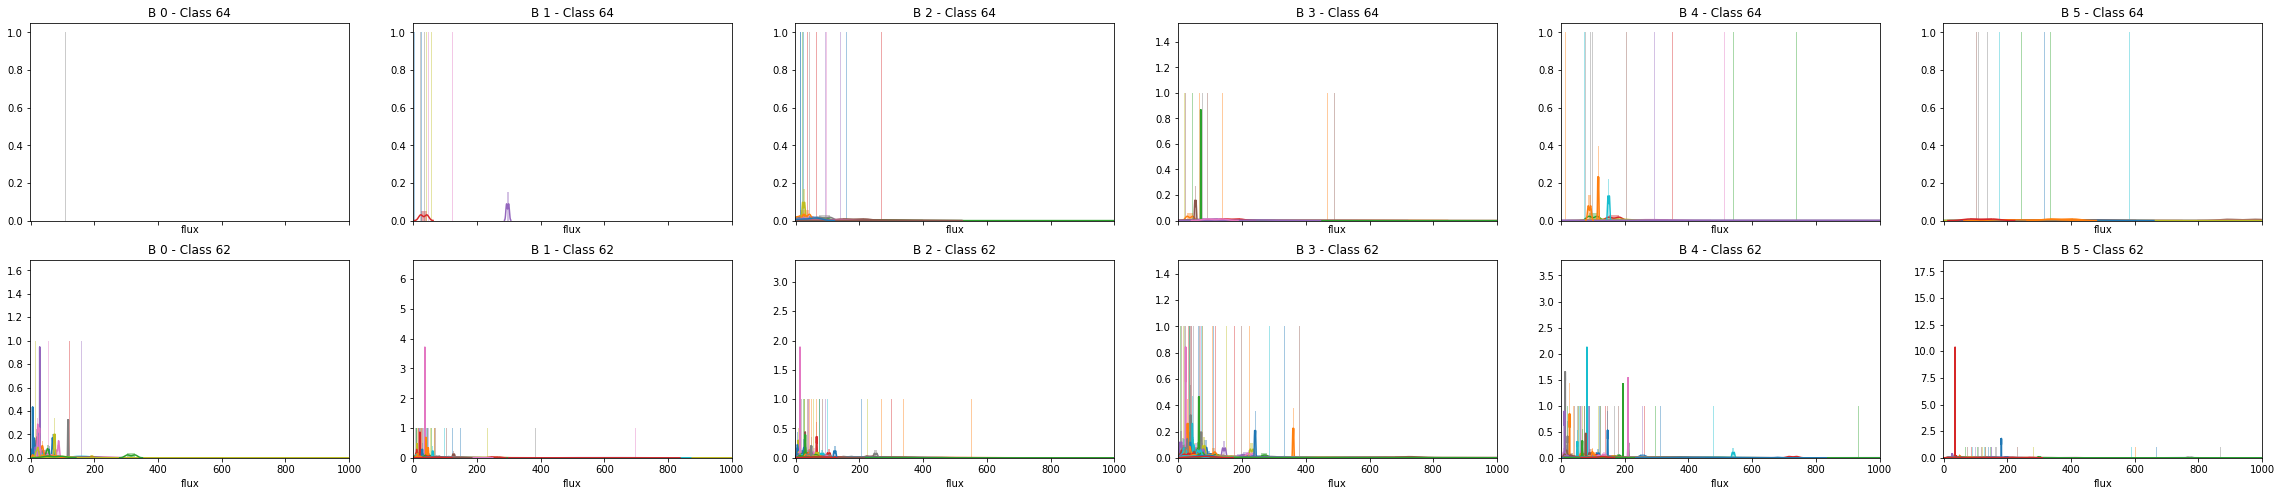

In [28]:
_cs = [64, 62]

f,axes = plt.subplots(len(_cs),6,figsize=(40,len(_cs)*4), sharex=True)

for i,tgt in enumerate(_cs):
    for oid in oids_by_class[tgt][:]:
        for pb in range(6):
            single_pb = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1.0),
                'flux'
            ]
            sns.distplot(single_pb, ax=axes[i, pb], label=f'band {pb:d}')
            axes[i, pb].set_title(f'B {pb:d} - Class {tgt:d}')

plt.xlim(-1,1000)
#f.savefig('../fluxz_err.png')

(0, 1)

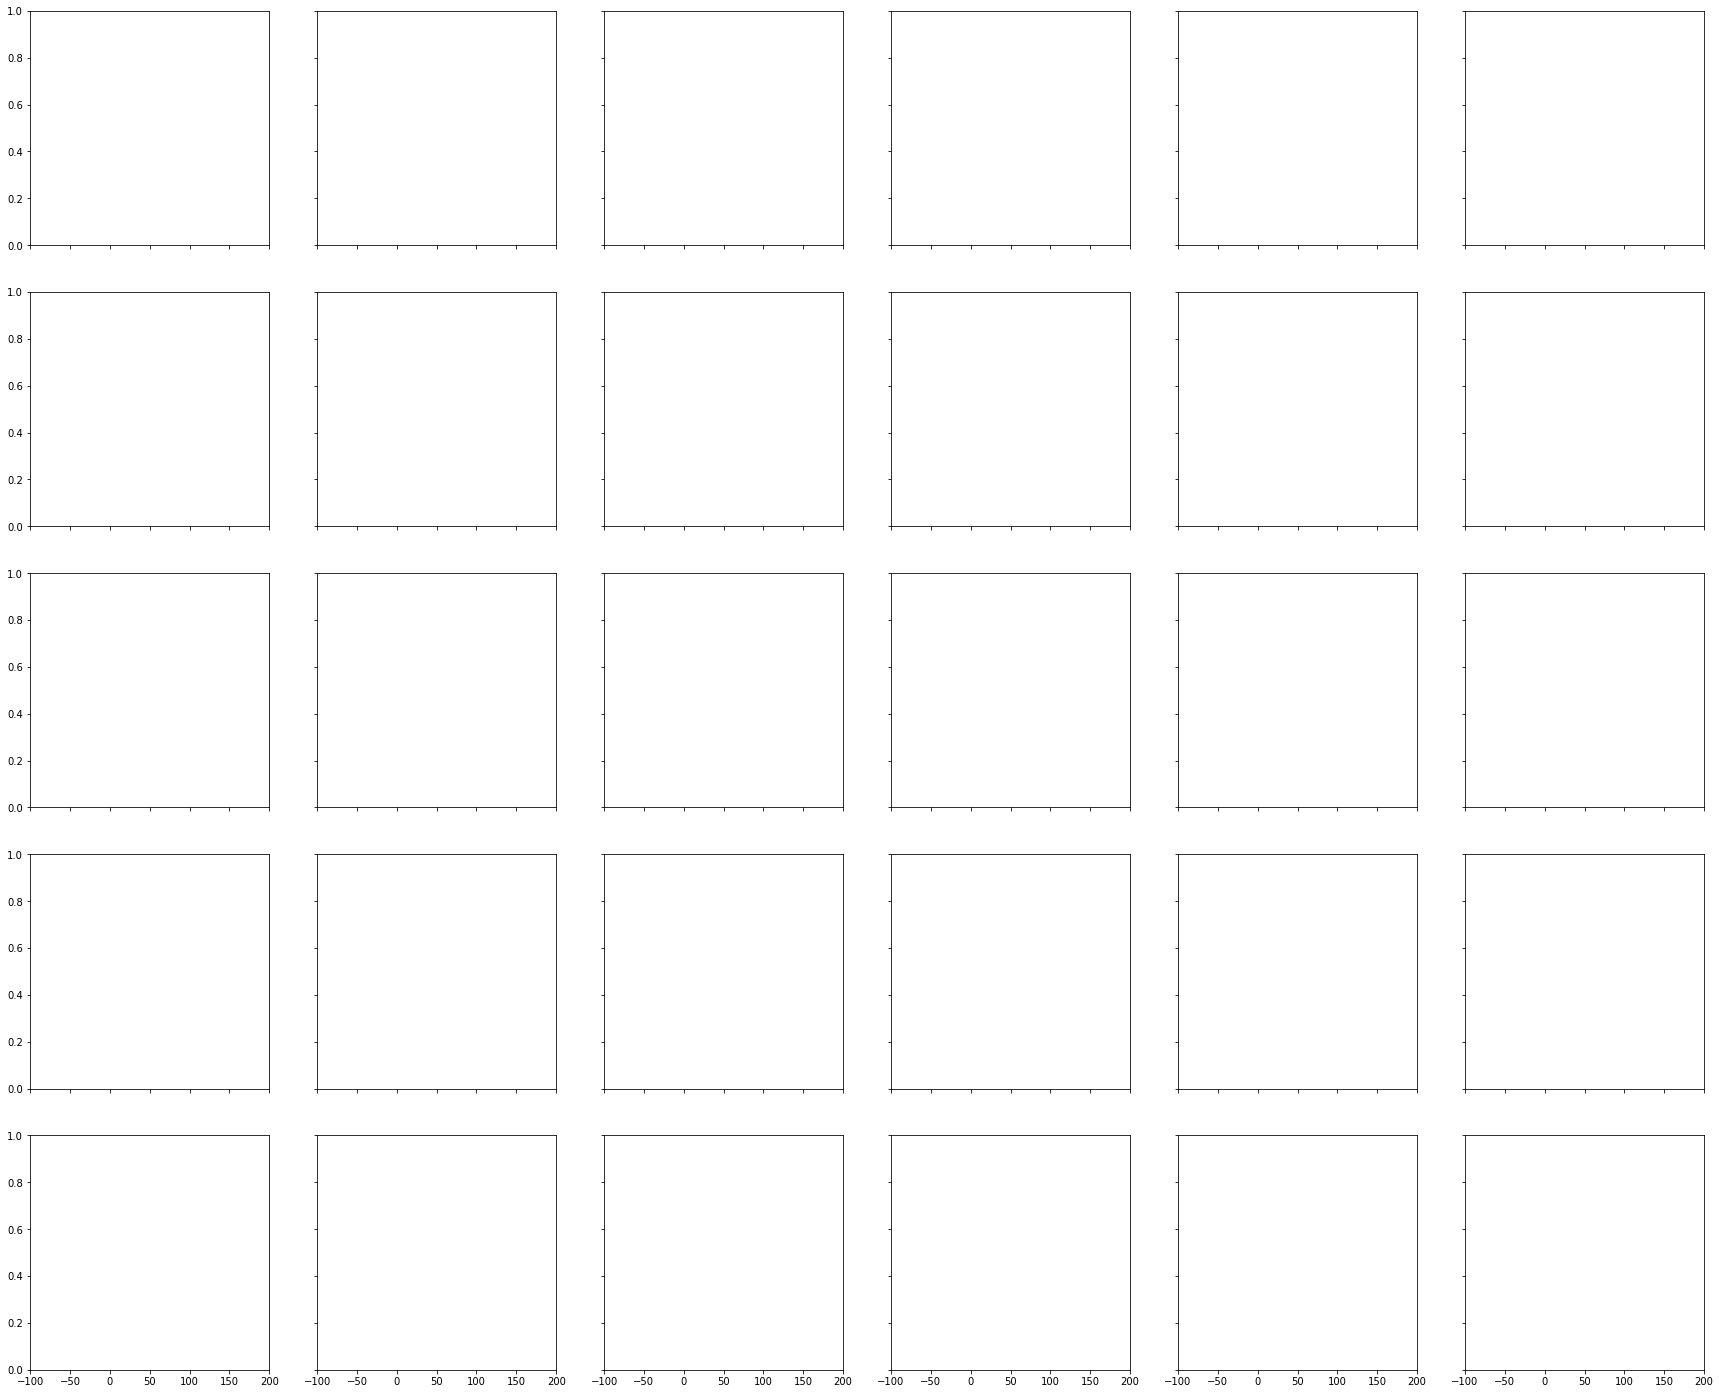

In [195]:
_cs = [52, 42, 62, 67, 90]
f,axes = plt.subplots(5,6,figsize=(30,5*len(_cs)), sharex=True, sharey=True)

all_ascending={
    52:[],
    42:[],
    62:[],
    67:[],
    90:[]
}
for i,tgt in enumerate(_cs):
    for oid in oids_by_class[tgt][:183]:
        
        flux_maxs = []
        for pb in range(6):
            flux = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'flux'
            ].values
            if len(flux)>=1:
                flux_maxs.append(np.max(flux))
        flux_max = np.max(flux_maxs)
        
        local_rel_maxs = []
        for pb in range(6):
            mjd = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'mjd'
            ].values
            flux = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'flux'
            ].values
            
            # Find flux peak to allign peaks
            if len(flux)>0:
                peak_pos = np.argmax(flux)
                flux /= flux_max
                mjd = mjd - mjd[peak_pos]
                local_rel_maxs.append(np.max(flux))

                #sns.scatterplot(x=mjd, y=flux, s=30, alpha=0.8, ax=axes[i, pb])
                #axes[i, pb].set_title(f'Band {pb:d} - Class {tgt:d}')
                #axes[i, pb].set_ylabel('')
        all_ascending[tgt].append(local_rel_maxs)

plt.xlim(-100,200)
plt.ylim(0,1)
#f.savefig('../flux_confusion_v1_small.png')

In [196]:
for cs in _cs:
    num_cases = len(all_ascending[cs])
    num_pos_cases = np.sum([c[-1]==1.0 for c in all_ascending[cs]])
    print(f'Ratio {num_pos_cases}/{num_cases} = {num_pos_cases/num_cases:.2f}')

Ratio 67/183 = 0.37
Ratio 51/183 = 0.28
Ratio 135/183 = 0.74
Ratio 70/183 = 0.38
Ratio 29/183 = 0.16


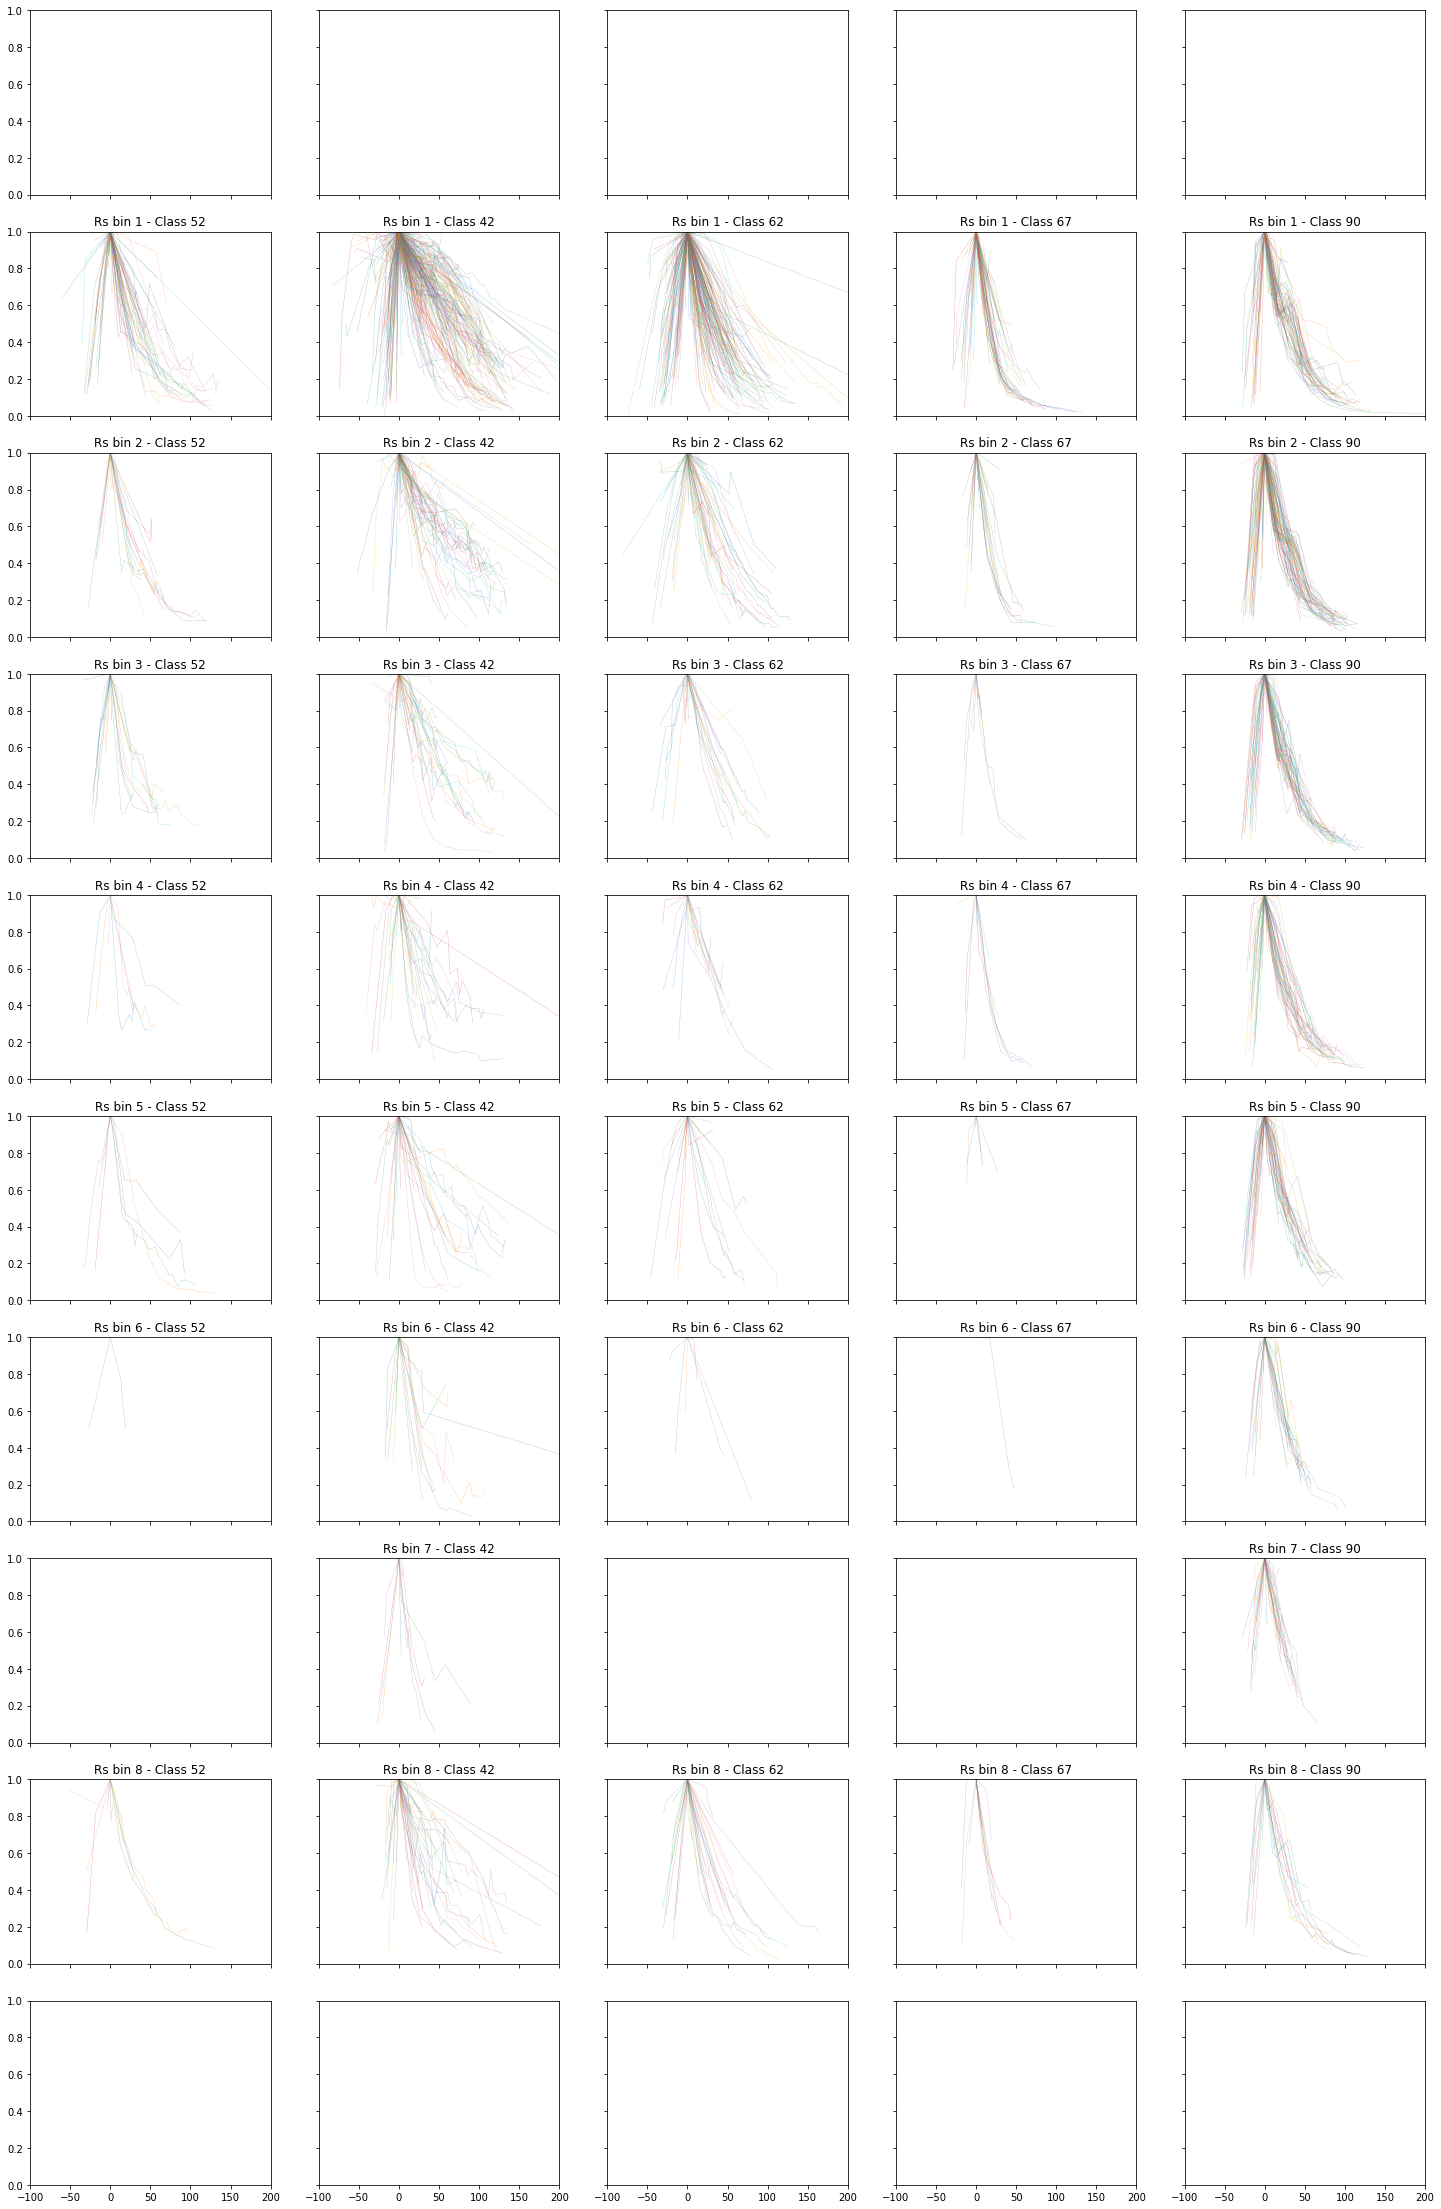

In [166]:
'''
REDSHIFT EDA
'''

_cs = [52, 42, 62, 67, 90]
rs_bins = range(10)
BAND = 4
f,axes = plt.subplots(len(rs_bins),len(_cs),figsize=(5*len(_cs),4*len(rs_bins)), sharex=True, sharey=True)
MAX_NUM = 500

for m, rs_bin in enumerate(rs_bins):
    for i,tgt in enumerate(_cs):
        for oid in oids_by_class[tgt][:MAX_NUM]:
            
            rs_oids = preds.loc[preds['rs_bin']==m, 'object_id'].values
            
            if oid in rs_oids:
                mjd = train.loc[
                    (train['object_id'] == oid) &
                    (train['passband'] == BAND) &
                    (train['detected'] == 1),
                    'mjd'
                ].values
                flux = train.loc[
                    (train['object_id'] == oid) &
                    (train['passband'] == BAND) &
                    (train['detected'] == 1),
                    'flux'
                ].values

                # Find flux peak to allign peaks
                if len(flux)>0:
                    peak_pos = np.argmax(flux)
                    flux /= flux[peak_pos]
                    mjd = mjd - mjd[peak_pos]

                    sns.lineplot(x=mjd, y=flux, linewidth=0.4, alpha=0.4, ax=axes[m, i])
                    axes[m, i].set_title(f'Rs bin {m:d} - Class {tgt:d}')
                    axes[m, i].set_ylabel('')

plt.xlim(-100,200)
plt.ylim(0,1)
f.savefig('../flux_rs_bin.png')

[[0.13114754 0.43715847 0.79234973 0.76502732 0.68306011 0.44262295]
 [0.13579212 0.38977368 0.7116513  0.70410729 0.70326907 0.46856664]
 [0.08264463 0.32024793 0.63842975 0.63842975 0.70867769 0.60123967]
 [0.00961538 0.24038462 0.58173077 0.59615385 0.625      0.39903846]
 [0.11975789 0.3873757  0.71768266 0.68568958 0.64288802 0.33938608]]


<Figure size 432x288 with 0 Axes>

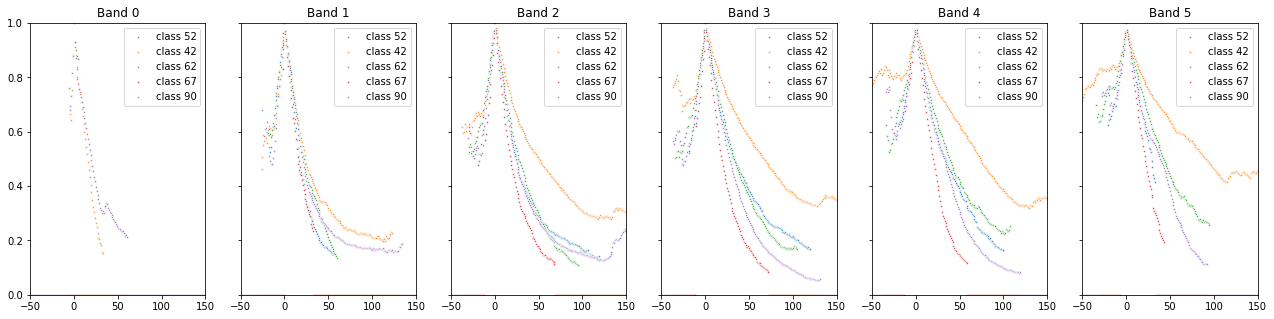

In [85]:
plt.cla()
plt.clf()

f,axes = plt.subplots(1,6,figsize=(22,5), sharex=True, sharey=True)

n_meas = np.zeros((5,6))
_classes = [52, 42, 62, 67, 90]

noids = np.array([len(oids_by_class[tgt]) for tgt in _classes])
MAX_X = 150
MIN_X = -50
n_divs = MAX_X-MIN_X+1

supernovae_models = {}

for i,tgt in enumerate(_classes):
    
    class_sn_models = []
    
    for pb in range(6):
        fluxes = []
        
        standard_time_stamps = np.linspace(MIN_X, MAX_X, n_divs)
        
        for oid in oids_by_class[tgt][:]:
            mjd = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'mjd'
            ].values
            flux = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'flux'
            ].values
            
            # Find flux peak to allign peaks
            if len(flux)>1:
                peak_pos = np.argmax(flux)
                flux /= flux[peak_pos]
                mjd = mjd - mjd[peak_pos]
                
                n_meas[i, pb] += 1
                
                # Interp flux to standard timestamps
                interp_flux = np.interp(standard_time_stamps, mjd, flux)
                fluxes.append([interp_flux, np.min(mjd), np.max(mjd)])
            
        # Build mean flux model only with interpolated pts (not extrapolated)
        flux = np.zeros(n_divs)
        for jj,ts in enumerate(standard_time_stamps):
            # For this timestamp grab only fluxes that interpolated this pt (not extra)
            sub_fluxes = []
            for f, min_time, max_time in fluxes:
                if ts > min_time and ts < max_time:
                    sub_fluxes.append(f)
            if len(sub_fluxes)>=20:
                flux[jj] = np.mean(sub_fluxes, axis=0)[jj]
            else:
                flux[jj] = 0

        sns.scatterplot(x=standard_time_stamps, y=flux, s=5, alpha=0.82, ax=axes[pb], label=f'class {tgt:d}')
        axes[pb].set_title(f'Band {pb:d}')
        axes[pb].set_ylabel('')
        
        class_sn_models.append(flux)
        
    supernovae_models[tgt] = class_sn_models

plt.legend()
plt.xlim(MIN_X,MAX_X)
plt.ylim(0,1)
print(n_meas/noids[:, None])

In [87]:
with open('../data/sn_models.pickle', 'wb') as handle:
    pickle.dump(supernovae_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

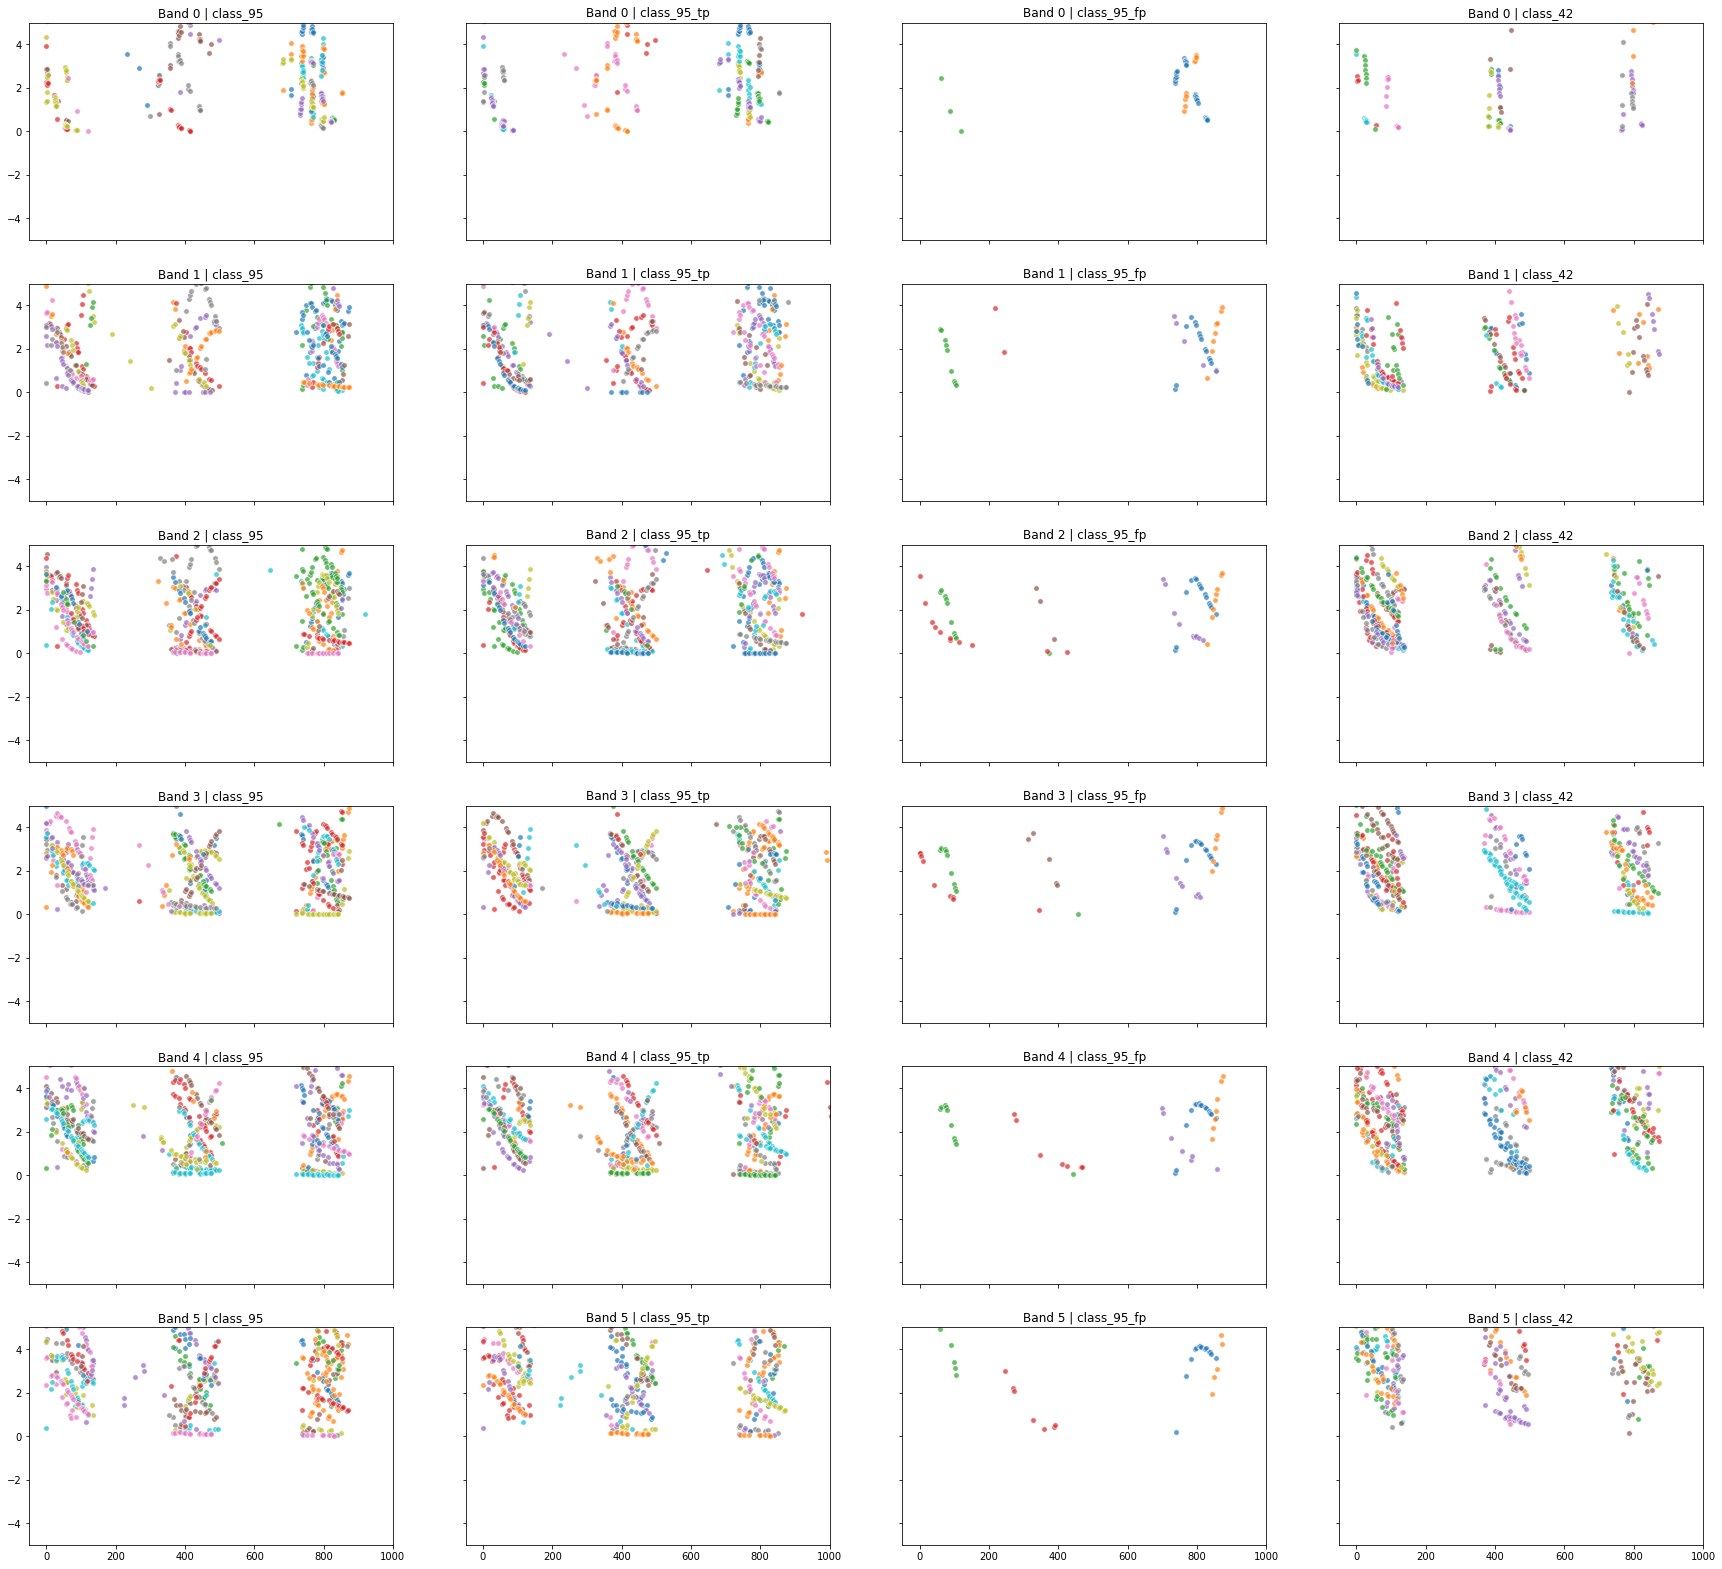

In [175]:
'''
Negative mining EDA
'''

preds = pd.read_hdf('../train_oof.h5')

true_class = 95
other_class = 42

MAX_OIDS = 50
true_oids = oids_by_class[true_class][:MAX_OIDS]
tp_oids = preds.loc[(preds['target'] == true_class) & (preds['pred'] == true_class), 'object_id'][:MAX_OIDS]
fp_oids = preds.loc[(preds['target'] == true_class) & (preds['pred'] == other_class), 'object_id'][:MAX_OIDS]
other_oids = oids_by_class[other_class][:MAX_OIDS]

oids_list = [true_oids, tp_oids, fp_oids, other_oids]
titles = [f'class_{true_class}', f'class_{true_class}_tp', f'class_{true_class}_fp', f'class_{other_class}',]

NBANDS = 6
f,axes = plt.subplots(NBANDS, len(oids_list), figsize=(NBANDS * 5, len(oids_list) * 7), sharex=True, sharey=True)

for iii, oid_list in enumerate(oids_list):
    for oid in oid_list:
        for pb in range(6):
            mjd_all = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb),
                'mjd'
            ].values
            
            mjd = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'mjd'
            ].values
            flux = train.loc[
                (train['object_id'] == oid) &
                (train['passband'] == pb) &
                (train['detected'] == 1),
                'flux'
            ].values

            # Reset mjd
            if len(flux)>1:
                peak_loc = np.argmax(flux)
                flux /= np.std(flux)
                mjd = mjd - np.min(mjd_all)
                
                sns.scatterplot(x=mjd, y=flux, s=30, alpha=0.7, ax=axes[pb, iii])
                axes[pb, iii].set_title(f'Band {pb:d} | {titles[iii]}')
                axes[pb, iii].set_ylabel('')

plt.xlim(-50,1000)
plt.ylim(-5,5)
f.savefig('../flux_negative_mining.png')

In [181]:
preds['target'].value_counts()

90    2313
42    1193
65     981
16     924
15     495
62     484
88     370
92     239
67     208
52     183
95     175
6      151
64     102
53      30
Name: target, dtype: int64

In [183]:
preds = pd.read_hdf('../train_oof.h5')

oids_by_class[90][oids_by_class[90] <5000]

array([ 745, 1124, 1598, 1920, 2072, 2330, 4389, 4595, 4819])

In [187]:
preds.groupby('pred')['hard_not_67'].sum()

pred
6      11.0
15    490.0
16    433.0
42    295.0
52     74.0
53      3.0
62     28.0
64     19.0
65    244.0
67      0.0
88    231.0
90    549.0
92    223.0
95     71.0
Name: hard_not_67, dtype: float32

In [199]:
preds.iloc[:3,1:108]

,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,mwebv,rs_bin,slope_mean_0,...,sn_52,sn_62,sn_67,sn_90,linreg_b1_back_mean,linreg_b1_front_mean,linreg_b1_back_std,linreg_b1_front_std,hard_not_67,6
0,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.017,0,0.136506,...,0.024116,0.025136,0.022638,0.024146,0.003349,-0.011660,0.000919,0.011974,1.0,0.000873
1,53.085938,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,0.007,8,0.159441,...,0.012115,0.014992,0.024894,0.014445,-0.018864,0.027851,0.024594,0.053228,1.0,0.000047
2,33.574219,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,0.021,1,0.000000,...,0.007904,0.005409,0.020438,0.007629,0.009107,-0.011246,0.005456,0.001407,0.0,0.000783
